# 2 - Ridge Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from common import *
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D
import sklearn.linear_model as lm

print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: /Users/gardpavels/uio/fysstk_proj1/FYS-STK4155-Prj1_report/code


## 2.1 Data
Defining and creating the data


In [2]:
features = 6
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
X = create_X(x, y, n=features) # Design Matrix
z = FrankeFunction(x,y)
# z += noise # Adding stochastic noise

## 2.3 - Finding optimal lambda for Ridge fit
First we find the optimal value for the lambda parameter by splitting the input data into training and test data. Than we fit the model using different values for lambda. For each lambda value we use the mean square error on the test data evaluate how god the fit is. The best lambda value is used to fit a new model with all data (not using train-test split). <br>
First we find the optimal parameter value of lambda, $\lambda$, by evaluating overfit from evaluation plot where we plot the values for MSE for training and test data

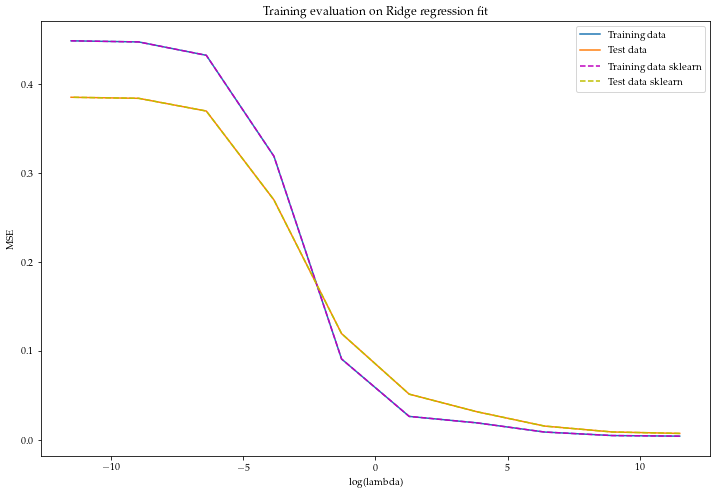

In [3]:
nbf_lambdas = 10
lambdas = np.logspace(-5,5, nbf_lambdas)
z_train_ridge = pd.DataFrame()
z_hat_train_ridge = pd.DataFrame()
z_test_ridge = pd.DataFrame()
z_hat_test_ridge = pd.DataFrame()


z_hat_train_ridge_sk = pd.DataFrame()
z_hat_test_ridge_sk = pd.DataFrame()

for lmb in lambdas:
    model_sk = lm.Ridge(lmb, fit_intercept=False)
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    model = RidgeRegression(lmb) # The model
    model.fit(X_train, z_train) # Fitting the model

    # Fitting the scikit Ridge model
    model_sk.fit(X_train, z_train)
   
    # Predictions our Ridge model
    z_hat_train = model.predict(X_train) # predict on train data
    z_hat_test = model.predict(X_test) # predict on test data

    # Predictions sklearn Ridge
    z_hat_train_sk = model_sk.predict(X_train) # predict on train data
    z_hat_test_sk = model_sk.predict(X_test) # predict on test data

    # Filling up dataframes
    z_train_ridge[lmb] = z_train.flatten() 
    z_hat_train_ridge[lmb] = z_hat_train.flatten()
    z_test_ridge[lmb] = z_test.flatten()
    z_hat_test_ridge[lmb] = z_hat_test.flatten()

    # Filling up sk dataframes
    z_hat_train_ridge_sk[lmb] = z_hat_train_sk.flatten()
    z_hat_test_ridge_sk[lmb] = z_hat_test_sk.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_ridge - z_hat_train_ridge) ** 2).mean()
mse_scores_test = ((z_test_ridge - z_hat_test_ridge) ** 2).mean()
mse_scors_train_sk = ((z_train_ridge - z_hat_train_ridge_sk) ** 2).mean()
mse_scores_test_sk = ((z_test_ridge - z_hat_test_ridge_sk) ** 2).mean()

# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_ridge - z_hat_train_ridge) ** 2).sum() / ((z_train_ridge - z_train_ridge.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_ridge - z_hat_test_ridge) ** 2).sum() / ((z_test_ridge - z_test_ridge.mean())**2).sum()  

# Plots
plt.figure(figsize=(12,8))
plt.plot(-np.log(lambdas), mse_scores_train, label="Training data")
plt.plot(-np.log(lambdas), mse_scores_test, label="Test data")

plt.plot(-np.log(lambdas), mse_scors_train_sk, 'm--', label="Training data sklearn")
plt.plot(-np.log(lambdas), mse_scores_test_sk, 'y--', label="Test data sklearn")

#plt.plot(mse_scores_train,-np.log(lambdas), label="Training data")
#plt.plot(mse_scores_test,-np.log(lambdas), label="Test data")
plt.xlabel("log(lambda)")
plt.ylabel("MSE")
plt.title("Training evaluation on Ridge regression fit")
plt.legend()
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_evaluate_fit.pdf")

Perform the same analysis as above, but with scaled data and fit intercept equal to false

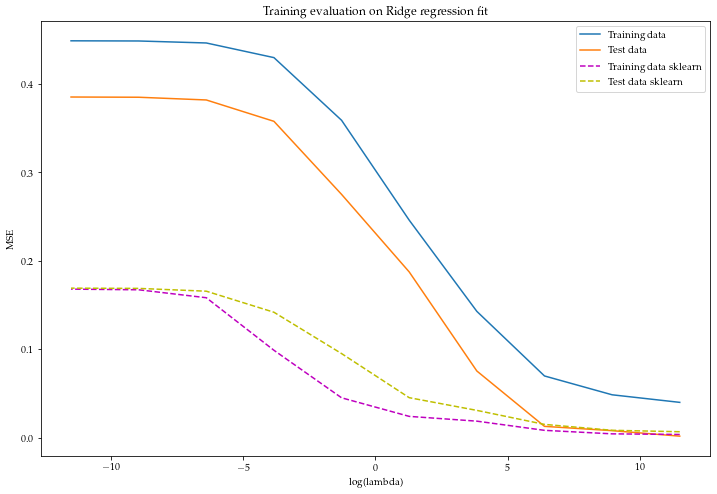

In [4]:
nbf_lambdas = 10
lambdas = np.logspace(-5,5, nbf_lambdas)
z_train_ridge = pd.DataFrame()
z_hat_train_ridge = pd.DataFrame()
z_test_ridge = pd.DataFrame()
z_hat_test_ridge = pd.DataFrame()


z_hat_train_ridge_sk = pd.DataFrame()
z_hat_test_ridge_sk = pd.DataFrame()

for lmb in lambdas:
    model_sk = lm.Ridge(lmb, fit_intercept=False)
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    model = RidgeRegression(lmb) # The model
    model.fit(X_train, z_train) # Fitting the model

    # Fitting the scikit Ridge model
    model_sk.fit(X_train, z_train)
   
    # Predictions our Ridge model
    z_hat_train = model.predict(X_train) # predict on train data
    z_hat_test = model.predict(X_test) # predict on test data

    # Predictions sklearn Ridge
    z_hat_train_sk = model_sk.predict(X_train) # predict on train data
    z_hat_test_sk = model_sk.predict(X_test) # predict on test data

    # Filling up dataframes
    z_train_ridge[lmb] = z_train.flatten() 
    z_hat_train_ridge[lmb] = z_hat_train.flatten()
    z_test_ridge[lmb] = z_test.flatten()
    z_hat_test_ridge[lmb] = z_hat_test.flatten()

    # Filling up sk dataframes
    z_hat_train_ridge_sk[lmb] = z_hat_train_sk.flatten()
    z_hat_test_ridge_sk[lmb] = z_hat_test_sk.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_ridge - z_hat_train_ridge) ** 2).mean()
mse_scores_test = ((z_test_ridge - z_hat_test_ridge) ** 2).mean()
mse_scors_train_sk = ((z_train_ridge - z_hat_train_ridge_sk) ** 2).mean()
mse_scores_test_sk = ((z_test_ridge - z_hat_test_ridge_sk) ** 2).mean()

# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_ridge - z_hat_train_ridge) ** 2).sum() / ((z_train_ridge - z_train_ridge.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_ridge - z_hat_test_ridge) ** 2).sum() / ((z_test_ridge - z_test_ridge.mean())**2).sum()  

# Plots
plt.figure(figsize=(12,8))
plt.plot(-np.log(lambdas), mse_scores_train, label="Training data")
plt.plot(-np.log(lambdas), mse_scores_test, label="Test data")

plt.plot(-np.log(lambdas), mse_scors_train_sk, 'm--', label="Training data sklearn")
plt.plot(-np.log(lambdas), mse_scores_test_sk, 'y--', label="Test data sklearn")

#plt.plot(mse_scores_train,-np.log(lambdas), label="Training data")
#plt.plot(mse_scores_test,-np.log(lambdas), label="Test data")
plt.xlabel("log(lambda)")
plt.ylabel("MSE")
plt.title("Training evaluation on Ridge regression fit")
plt.legend()
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_evaluate_fit.pdf")

# 2.3.1
Finding the optimal lambda by using the bootstrap resampling technique over different values of lamda. For each value of lambda, a bias-variance tradeoff chart as in exercise 2 is created. 

In [5]:
n_bootstraps = 100
maxdegree = 12
for lmb in lambdas:
    MSE_test = np.zeros(maxdegree)
    MSE_train = np.zeros(maxdegree)
    polydegree = np.arange(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)

    for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
        model = RidgeRegression(lmb)
        X = create_X(x, y, n=degree)
        X_train, X_test, z_train, z_test = prepare_data(X, z)

        # Reshape for broadcasting
        z_test_ = np.reshape(z_test, newshape=(z_test.shape[0],1))
        z_train_ = np.reshape(z_train, newshape=(z_train.shape[0],1))
        
        # Scaling data and preparing output arrays 
        scaler = StandardScaler()
        scaler.fit(X_train)
        #X_train_scaled = scaler.transform(X_train)
        #X_test_scaled = scaler.transform(X_test)
        z_pred = np.empty((z_test.shape[0], n_bootstraps))
        z_fit = np.empty((z_train.shape[0], n_bootstraps))

        # Bootstrapping
        for i in range(n_bootstraps):
            x_, z_ = resample(X_train, z_train)
            model.fit(X_train, z_train)
            z_pred[:,i] = model.predict(X_test)
            z_fit[:,i] = model.predict(X_train)

        MSE_test[degree] = np.mean( np.mean((z_test_ - z_pred)**2, axis=1, keepdims=True) )
        MSE_train[degree] = np.mean( np.mean((z_train_ - z_fit)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True))

    plt.figure()
    plt.plot(polydegree, MSE_test,"m", label='MSE\_test')
    plt.plot(polydegree, MSE_train,"c", label='MSE\_train')

    plt.plot(polydegree, bias,"g--", label='bias')
    plt.plot(polydegree, variance,"r--", label='Variance')

    plt.title(f"Bias-Variance for log10(lambda) = {np.log10(lmb)}")
    plt.xlabel("Model complexity / Polynomial Degree")
    plt.ylabel("Prediction Error")

    plt.grid(True)
    plt.legend()
    plt.show()

    display(model.summary())
      


Looping through polynomials up to 12 degrees with 100 bootstraps:   0%|          | 0/12 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

## 2.4 Analysis of plots and training metrics
Do the analysis.......

Conclusion:<br>
Based on the analysis, we conclude that a model complexity of degree 5 yields the most optimal fit.

## 2.5 plot of the model using the most optimal parameters

In [ ]:
scale = False

if scale:
    # Data Scalling
    X_scaler = StandardScaler()
    X_scaler.fit(X)
    X_train = X_scaler.transform(X_train)
    z_train = np.expand_dims(z,axis=1)  
    z_scaler = StandardScaler()
    z_scaler.fit(z_train)
    z_train = z_scaler.transform(z_train)
else:
    X_train = X; z_train = z

lam = -1.1
model = RidgeRegression(lam) # The model
model.fit(X_train, z_train) # Fitting the model
z_hat = model.predict(X_train) # predict on train data

# Evaluatation metrics
# TODO:
results_df = pd.DataFrame(columns=["MSE", "R2-score"], index=["Training data", "Test data"])
results_df["MSE"] = MSE(z, z_hat)
results_df["R2-score"] = R2(z, z_hat)
results_df.to_csv(f"{REPORT_DATA}redge_reg_lambda_{lam}.csv")

# Plot
fig = plt.figure()#figsize=(8,8))
ax = plt.axes(projection='3d')
ax.title.set_text(f"Ridge regression fit to the Franke Function\nDegree {degree},$\lambda$:{lam}")
#ax.view_init(elev=5., azim=85.0)
ax.view_init(elev=30., azim=-25.0)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.scatter3D(x,y,z,c=z, cmap=cm.coolwarm, marker = '.')
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_best_fit.pdf")